In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import FlatLambdaCDM
import copy
import corner
import matplotlib.colors as colors
from getdist import plots
from getdist import MCSamples
import seaborn as sns
import palettable

import paperfig as pf
from kinematics_likelihood import KinematicLikelihood
from data_util import *

pf.set_fontscale(2.)

from plot_util import *

In [2]:
is_blind = True
savefig = True
d_index = 4

In [3]:
bic_pl = get_bic('jampy', 'ifu', 'constant', 'axisymmetric', 'powerlaw', 15, 'oblate', burnin=-2)
bic_comp = get_bic('jampy', 'ifu', 'constant', 'axisymmetric', 'composite', 15, 'oblate', burnin=-2)

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


In [4]:
comp_weight = np.exp((bic_pl - bic_comp) / 2.)

comp_weight = 0

In [5]:
mc_samples_pl, _, _, _ = get_getdist_samples('jampy', 'ifu', 'constant',
                    'axisymmetric', lens_model_type='powerlaw', snr=15,
                    oblate_fraction=0.82, blind_D=None)

mc_samples_comp, _, _, _ = get_getdist_samples('jampy', 'ifu', 'constant',
                    'axisymmetric', lens_model_type='composite', snr=15,
                    oblate_fraction=0.82, blind_D=None)

length = int(comp_weight * mc_samples_pl.samples.shape[0])


D_d_array = np.concatenate((mc_samples_pl.samples[:, d_index], mc_samples_comp.samples[:length, d_index+1]), axis=0)

print(D_d_array.shape)

(4800, 8) (4800, 8) (4799, 8) 0.82
Removed no burn in
(5400, 9) (5400, 9) (5400, 9) 0.82
Removed no burn in
(4799,)


In [6]:
from scipy.stats import gaussian_kde


# if is_blind:
#     chain[:, d_index] = chain[:, d_index] #+ np.random.normal(0, 100)

D_d_kde = gaussian_kde(D_d_array)

In [7]:
def log_prior_uniform(params):
    """
    """
    h0, om_m = params
    
    if not 10 < h0 < 130:
        return -np.inf
    
    if not 0.05 < om_m < 0.5:
        return -np.inf
    
    return 0.


def log_prior_normal(params):
    """
    """
    h0, om_m = params
    if not 10 < h0 < 130:
        return -np.inf
    
    return -0.5 * (om_m - 0.334)**2 / 0.018**2

In [8]:
from astropy.cosmology import FlatLambdaCDM

def log_likelihood(params):
    """
    """
    h0, om_m = params
    cosmo = FlatLambdaCDM(H0=h0, Om0=om_m)
    
    D_d = cosmo.angular_diameter_distance(0.295).value
    
    return np.log(D_d_kde(D_d))


def log_probability_uniform_prior(params):
    """
    """
    prior = log_prior_uniform(params)
    
    if np.isinf(prior):
        return prior
    else:
        return log_likelihood(params) + prior
    
    
def log_probability_normal_prior(params):
    """
    """
    prior = log_prior_normal(params)
    
    if np.isinf(prior):
        return prior
    else:
        return log_likelihood(params) + prior
    

# run emcee

In [9]:
import emcee

In [10]:
def blind_chain(chain):
    """
    """
    if not is_blind:
        return chain
    
    median = np.median(chain[..., 0])
    chain[..., 0] -= median
    chain[..., 0] /= median
    
    return chain

In [11]:
# uniform prior

nwalkers, ndim = 40, 2
pos = np.array([70, 0.3]) + 1e-4 * np.random.randn(nwalkers, ndim)


sampler_uniform = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_uniform_prior, 
)

sampler_uniform.run_mcmc(pos, 1000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.97it/s]


In [12]:
chain_uniform = sampler_uniform.get_chain()

chain_uniform = blind_chain(chain_uniform)

## normal prior

In [13]:
pos = np.array([70, 0.3]) + 1e-4 * np.random.randn(nwalkers, ndim)


sampler_normal = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_normal_prior, 
)

sampler_normal.run_mcmc(pos, 1000, progress=True);

 14%|█████████████████▏                                                                                                             | 135/1000 [00:02<00:13, 66.10it/s]/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_29551/3301284170.py:11: RuntimeWarning: divide by zero encountered in log
  return np.log(D_d_kde(D_d))
 48%|████████████████████████████████████████████████████████████▎                                                                  | 475/1000 [00:07<00:07, 65.82it/s]/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_29551/3301284170.py:11: RuntimeWarning: divide by zero encountered in log
  return np.log(D_d_kde(D_d))
 48%|█████████████████████████████████████████████████████████████▏                                                                 | 482/1000 [00:07<00:07, 65.93it/s]/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_29551/3301284170.py:11: RuntimeWarning: divide by zero encountered in log
  return np.log(D_d_kde(D_d))
100%|█████

In [14]:
chain_normal = sampler_normal.get_chain()

chain_normal = blind_chain(chain_normal)

## plot

In [15]:
thin = 10
burnin = -500

samples_uniform = chain_uniform[burnin::thin, :, :].reshape((-1, 2))
samples_normal = chain_normal[burnin::thin, :, :].reshape((-1, 2))

samples_normal.shape

(2000, 2)

In [16]:
labels = ['H0', 'Om_0']

if is_blind:
    latex_labels = ['{\\rm blinded\\ } H_0', '\\Omega_{\\rm m}']
else:
    latex_labels = ['H_0\\ {(\\rm km\\ s^{-1}\\ Mpc^{-1})}', '\\Omega_{\\rm m}']


mc_samples_uniform = MCSamples(samples=samples_uniform,
                               names=labels,
                               labels=latex_labels
                               )

mc_samples_normal = MCSamples(samples=samples_normal,
                               names=labels,
                               labels=latex_labels
                               )

Removed no burn in
Removed no burn in


In [17]:
np.std(samples_uniform[:, 0]), np.std(samples_normal[:, 0])

(0.06288408698370358, 0.05588639605828375)

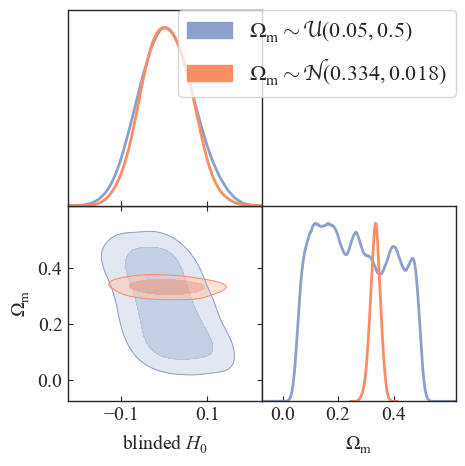

In [18]:
pf.set_fontscale(2.)

font_scale = 1

g = plots.getSubplotPlotter(subplot_size=2.5)
g.settings.lw_contour = 1.
g.settings.alpha_factor_contour_lines = 2.
g.settings.solid_contour_palefactor = 0.5

g.settings.axes_fontsize = 16 * font_scale
g.settings.lab_fontsize = 16 * font_scale

g.settings.legend_fontsize = 18 * font_scale

colors = [pf.cb2_blue, pf.cb2_orange, pf.cb2_emerald, pf.cb_grey]

legend_labels = [r'$\Omega_{\rm m} \sim \mathcal{U}(0.05, 0.5)$', 
                 r'$\Omega_{\rm m} \sim \mathcal{N}(0.334, 0.018)$']

g.triangle_plot([mc_samples_uniform, mc_samples_normal],
                legend_labels=legend_labels,
                filled=True, shaded=False,
                alpha_filled_add=.5,
                contour_lws=[2 for l in legend_labels],
                contour_ls=['-' for l in legend_labels],
                # filled=False,
                # contour_colors=[sns.xkcd_rgb['emerald'], sns.xkcd_rgb['bright orange']],
                contour_args={'alpha': .5},
                # line_args={'lw': 7., "zorder": 30},
                # line_args={'lw': 1., 'alpha': 1.}
                contour_colors=colors,
                #                     param_limits={'dphi_AB': (-0.45, 0.15),
                #                                   'dphi_AC': (-0.45, 0.15),
                #                                   'dphi_AD': (-0.45, 0.15),
                #                                   'lambda_int': (0.3, 3), 'a_ani': (0.5, 5.)},
                )

# g.settings.smooth_scale_2D = 4
# g.settings.smooth_scale_1D = 4



# g.savefig('')

In [19]:
6 / 80

0.075

In [20]:
if savefig:
    g.fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/H0_plot.pdf',
                  bbox_inches='tight'
                 )

In [21]:
1 - 0.2**2

0.96

In [22]:
1 - 1.5**2

-1.25